In [1]:
import pandas as pd
import numpy as np
from pydataset import data
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

from telco_pipeline import get_data_from_sql, peekatdata, split, df_value_counts, percent_missing, clean_data, encode, scale_minmax

### Walkthroughs before project

-What are the profiles of the customers who are churning? In presentation

#How do you deal with the column that converts monthly tenure to annual?

-Don't just identify that people leave bc they can, but what are the drivers that make them leave?

-Answer questions in exploration and analysis stages. Add comments and notes in notebook about why you're doing what you're doing and what your conclusions are.

-Don't deliver the data without your assessment of what is going on even if you add "I would need to assess this, but..."

-This "leader" wants to know all of the data behind our assessments. A diagram of the work flow and what you did is great.

-How likely is your model to accurately predict churn, return False positives and false negatives?

-Your .py files do NOT have to be exactly the ones and names of what is laid out in the project.

-If you transform data in a column, then you need to explain why you did that. ie. if you scale data, why did you do that?

#Add context (text) to numbers that make them meaningful.

-Include Google slide summarizing your model with links in your README.

-Project Planning from project outline would be good for the structure of your README file. ie. - data dictionary.

-Make a task list that lays out what you need to do at each stage of the pipeline. This could look like headers in your notebook.

-Exploration is when you would to do your t-tests, chi-squared tests.

-Train multiple models, different algorithms, but also change hyperparameters for the same model. ie. - k=2, k=3, k=4, diff features in same algorithm.

-You can decide what your cutoff point will be when deciding what the probability should be to predict churn or not churn at the end.

-Baseline #1 is proportion of churn to not churn. Find this rate first! It needs to be better than 60% accurate.

-Baseline #2 is doing minimal prep and running it through a model. 

-Model #3 is your MVP. Explore and answer the required questions. Prepare data to go into other algorithms (encoding or scaling as needed). Some automated feature selection here, too. Make predictions on this data

-Other Modeling - to gain more insight but beyond simple answers of basic questions. This would be where you include extra feature engineering. 

## Need to do

- encode internet_service_type_id

- decide about combining phone_service and multiple_lines

- figure out how to look at tenure cohort

- find price threshold for specific services where the liklihood of churn increases

- look again at churn rate for month-to-month customers vs 1-year for rate of churn

- Google Slide explaining model

- Google Presenatation

- CSV wth customer_id, probability of churn, and the prediction of churn

- .py file that will transform data as needed to replicate findings in notebook

### Acquistion

- Here I use my function to bring in data using a sql query
    
- My query brought over everything from all of the tables together,
    so I could look at the data before deciding how to clean and process.

In [2]:
df = get_data_from_sql()

### Data Prep

- I created a function that returns important info on the dataframe.

In [3]:
peekatdata(df)

DataFrame Shape:

(7043, 24)

Info about:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
payment_type_id             7043 non-null int64
internet_service_type_id    7043 non-null int64
contract_type_id            7043 non-null int64
customer_id                 7043 non-null object
gender                      7043 non-null object
senior_citizen              7043 non-null int64
partner                     7043 non-null object
dependents                  7043 non-null object
tenure                      7043 non-null int64
phone_service               7043 non-null object
multiple_lines              7043 non-null object
online_security             7043 non-null object
online_backup               7043 non-null object
device_protection           7043 non-null object
tech_support                7043 non-null object
streaming_tv                7043 non-null object
streaming_movies            7043 non-null object
paperless_billing     

- I created and used a function to decide whether to bin data for the value counts.

- I'm not worried about customer_id's unique counts because each is unique, and I will end up dropping this column before running it through a model.

- That leaves tenure, monthly_charges, and total_charges with a large number of unique values which may benefit from binning.

In [4]:
valcount_df = df_value_counts(df)
valcount_df

,0
payment_type_id,4
internet_service_type_id,3
contract_type_id,3
customer_id,7043
gender,2
senior_citizen,2
partner,2
dependents,2
tenure,73
phone_service,2


- I want to decide if and which rows or columns should be dropped.

- Running .value_counts() on total charges column showed me it has 11 values that are blank space. These are most likely for customers who have not had the service long enough to have a total_charge.

- Considering these findings, I will create and run a function that replaces the blank values with NaN and returns the percent of missing values in each column in order to make my final decision about dropping rows that contain NaNs.

- I'm including in this function a line to drop customer_id as I will not be needing this column.

In [5]:
df["total_charges"].value_counts(dropna=False)

           11
20.2       11
19.75       9
20.05       8
19.65       8
19.9        8
45.3        7
19.55       7
19.45       6
20.25       6
20.15       6
20.45       5
20.3        5
19.4        4
69.9        4
44.4        4
19.85       4
70.6        4
20.35       4
74.7        4
20.5        4
19.3        4
49.9        4
50.15       4
75.3        4
20.4        4
69.6        4
19.2        4
19.5        4
69.95       4
69.65       4
19.95       4
44          4
20          3
44.75       3
55.7        3
45.85       3
70.15       3
70.1        3
84.5        3
35.9        3
74.9        3
305.55      3
50.6        3
383.65      3
69.1        3
19.25       3
75.35       3
220.45      3
74.6        3
85.5        3
20.9        3
80.55       3
25.25       3
50.45       3
74.3        3
69.25       3
20.55       3
70.45       3
470.2       3
70.3        3
86.05       3
20.1        3
45.7        3
45.1        3
19.1        3
24.4        3
24.8        3
1284.2      3
50.75       3
74.35       3
85    

- This function reveals that only total_charges has missing values, and the percent of missing values is .16%.

- This confirms my decision to drop the rows with NaNs.


In [6]:
percent_missing(df)

payment_type_id             0.000000
internet_service_type_id    0.000000
contract_type_id            0.000000
customer_id                 0.000000
gender                      0.000000
senior_citizen              0.000000
partner                     0.000000
dependents                  0.000000
tenure                      0.000000
phone_service               0.000000
multiple_lines              0.000000
online_security             0.000000
online_backup               0.000000
device_protection           0.000000
tech_support                0.000000
streaming_tv                0.000000
streaming_movies            0.000000
paperless_billing           0.000000
monthly_charges             0.000000
total_charges               0.156183
churn                       0.000000
contract_type               0.000000
internet_service_type       0.000000
payment_type                0.000000
dtype: float64

- Here I am running my function clean_data to replace empty space values in total_charges with NaN, dropping the rows with Nan, dropping customer_id and confirming the drop with an .isnull().sum().

In [7]:
df = clean_data(df)
df.isnull().sum()

payment_type_id             0
internet_service_type_id    0
contract_type_id            0
gender                      0
senior_citizen              0
partner                     0
dependents                  0
tenure                      0
phone_service               0
multiple_lines              0
online_security             0
online_backup               0
device_protection           0
tech_support                0
streaming_tv                0
streaming_movies            0
paperless_billing           0
monthly_charges             0
total_charges               0
churn                       0
contract_type               0
internet_service_type       0
payment_type                0
dtype: int64

- Here I will transform dataframe values from "Yes" and "No"/"No phone service"/"No internet service" to True/False, so it is more intuitive to understand during exploration and interpretation.

- Female/Male will be denoted in the "gender" column by binary ints.

In [8]:
df.replace(to_replace=['No', 'Yes'], value=[False, True], inplace=True)
df.replace(to_replace=['No phone service'], value=[False], inplace=True)
df.replace(to_replace=['Female', 'Male'], value=[1, 0], inplace=True)
df.replace(to_replace=['No internet service'], value=[False], inplace=True)
df.dtypes

payment_type_id               int64
internet_service_type_id      int64
contract_type_id              int64
gender                        int64
senior_citizen                int64
partner                        bool
dependents                     bool
tenure                        int64
phone_service                  bool
multiple_lines                 bool
online_security                bool
online_backup                  bool
device_protection              bool
tech_support                   bool
streaming_tv                   bool
streaming_movies               bool
paperless_billing              bool
monthly_charges             float64
total_charges               float64
churn                          bool
contract_type                object
internet_service_type        object
payment_type                 object
dtype: object

- Here I compute a new feature comleted_years translating tenure from months to years. 

- I want to use this later to look at month-to-month and 1-year contract customers.


In [9]:
df["completed_years"] = round(df["tenure"] / 12)
df["completed_years"].value_counts().sort_index()

0.0    1470
1.0    1156
2.0    1004
3.0     715
4.0     868
5.0     786
6.0    1033
Name: completed_years, dtype: int64

- I decided not to create a new column phone_id that captures phone_service and multiple_lines into a single int variable. I want to keep this information seperate.


- Here I add a new column "family" that combines "dependents" and "partner" and is True for either having dependents or family or False for having neither.

Data Dictionary:

- True - partner or dependents, False - neither partner or dependents

In [10]:
df['family'] = (df.partner == True) | (df.dependents == True)

- Here I added a new column streaming_services of dtype bool that combines streaming_movies and streaming_tv into one. If the customer has either of these, the value is True. 

- I decided to combine these based on the results of my heat map in exploration. These two variables are highly correlated with each other.

In [11]:
df["streaming_services"] = (df.streaming_movies == True) | (df.streaming_tv == True)

- Here I added a column online_security_backup of dtype int that combines
online_security and online_backup dependents and partner and is dtype int.

Data Dictionary: 
    
- (0 = none, 1 = online security, 2 = online backup, 3 = both)

In [12]:
df["online_services"] = df.online_security + df.online_backup + df.device_protection + df.tech_support
df["online_services"].value_counts()

True     4245
False    2787
Name: online_services, dtype: int64

- Here I am checking my data types to begin cleaning up my dataframe, transforming all categorical/object dtypes to numerical and dropping columns I used to create the new, merged columns above.

In [13]:
df = df.drop(columns=["streaming_tv", "streaming_movies", "contract_type", "internet_service_type", "payment_type", "payment_type_id", "paperless_billing", "online_security", "online_backup", "device_protection", "tech_support", "partner", "dependents"])

In [14]:
df.dtypes

internet_service_type_id      int64
contract_type_id              int64
gender                        int64
senior_citizen                int64
tenure                        int64
phone_service                  bool
multiple_lines                 bool
monthly_charges             float64
total_charges               float64
churn                          bool
completed_years             float64
family                         bool
streaming_services             bool
online_services                bool
dtype: object

In [15]:
df.shape

(7032, 14)

- Here I am ready to split the data 70/30 train/test using my split function.


In [16]:
train, test = split(df=df, target="churn", train_prop=.70, seed=123)

train.head()
train.shape

(4922, 14)

#### Encode columns:

- I'm going to run my encode function on the columns internet_service_type_id and contract_type_id, so that I have the versatility to run those variables through multiple models.

- After I create the new encoded columns, I will drop the original columns I used to create the new encoded ones.

In [17]:
train, test, int_encoder, ohe = encode(train, test, "internet_service_type_id")

In [18]:
train.rename(columns={1 : "dsl", 2 : "fiber", 3 : "none"}, inplace = True)
test.rename(columns={1 : "dsl", 2 : "fiber", 3 : "none"}, inplace = True)

In [19]:
train, test, int_encoder, ohe = encode(train, test, "contract_type_id")

In [20]:
train.rename(columns={1 : "monthly", 2 : "1-year", 3 : "2-year"}, inplace = True)
test.rename(columns={1 : "monthly", 2 : "1-year", 3 : "2-year"}, inplace = True)

In [21]:
#train.drop(columns=["internet_service_type_id", "contract_type_id"], axis=1, inplace=True)

In [22]:
train.head()

,internet_service_type_id,contract_type_id,gender,senior_citizen,tenure,phone_service,multiple_lines,monthly_charges,total_charges,churn,completed_years,family,streaming_services,online_services,dsl,fiber,none,monthly,1-year,2-year
5968,3,1,0,0,10,True,False,20.00,198.60,False,1.0,False,False,False,0.0,0.0,1.0,1.0,0.0,0.0
3585,2,1,0,0,4,True,True,90.65,367.95,False,0.0,False,True,True,0.0,1.0,0.0,1.0,0.0,0.0
6987,3,3,1,0,40,True,False,20.15,777.35,False,3.0,True,False,False,0.0,0.0,1.0,0.0,0.0,1.0
5060,2,2,0,0,71,True,True,113.15,7953.25,False,6.0,True,True,True,0.0,1.0,0.0,0.0,1.0,0.0
3992,2,1,0,1,18,True,True,93.90,1743.90,False,2.0,False,True,True,0.0,1.0,0.0,1.0,0.0,0.0


In [23]:
df.dtypes

internet_service_type_id      int64
contract_type_id              int64
gender                        int64
senior_citizen                int64
tenure                        int64
phone_service                  bool
multiple_lines                 bool
monthly_charges             float64
total_charges               float64
churn                          bool
completed_years             float64
family                         bool
streaming_services             bool
online_services                bool
dtype: object

- I need to address the categrical data that is represented by integers in the columns:

    -internet_service_type_id
    -contract_type_id
    
- These may need to be encoded to be meaningful

### Create x and y variables for exploration and modeling

In [24]:
y_train = train[["churn"]]
y_test = test[["churn"]]

In [25]:
x_train = train.drop(columns="churn")
x_test = test.drop(columns="churn")

- I will run my first model without scaling and return to this step for my MVP below.


### Data Exploration

#### A look at the distribution of overall total churn

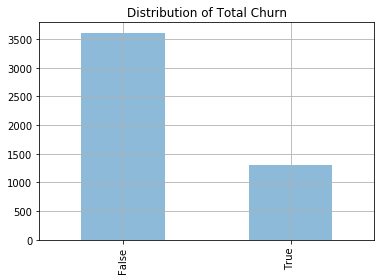

In [26]:
train.churn.value_counts().sort_index().plot(kind = "bar",alpha = .5)
plt.title("Distribution of Total Churn")
plt.grid(b = True , which = "major")

#### I created visualizations exploring interactions of variables (independent with independent and independent with dependent). My goal was to identify features that are related to churn, identify integrity issues, understand how the data works.

- A quick heatmap to explore correlations between independent variables and dependent target variable and independent variables with each other.

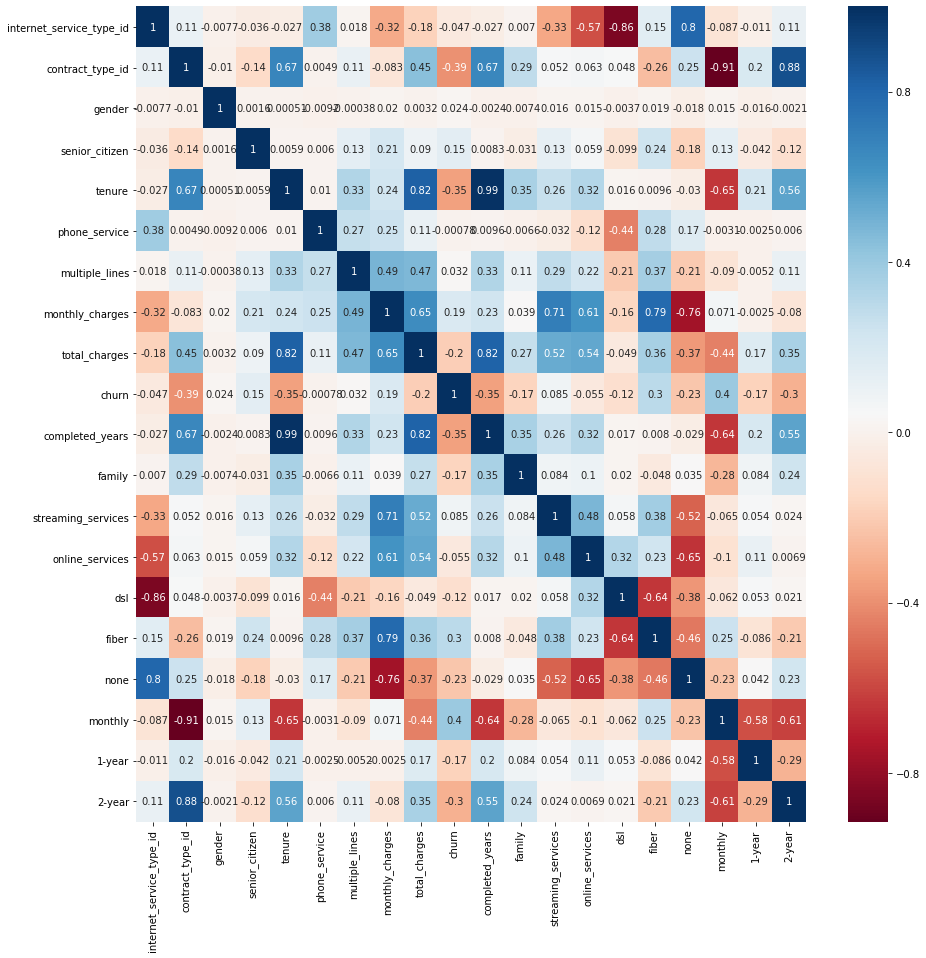

In [27]:
plt.figure(figsize=(15,15))
sns.heatmap(train.corr(), cmap='RdBu', annot=True)

#### Are there features that indicate higher propensity to churn?

According to the correlation figures on the heatmap, contract_type_id (39%), tenure and completed_tenure (35%), and total_charges (.20) have the highest correlations with the target of churn. Monthly_charges (19%), family (17%), and senior_citizen (15%) variables have lesser correlations, but they are high enough to remain of interest as features that could add some predictive accuracy to a model.

#### Could the month they signed up influence churn? 
Here I plot the rate of churn on a line chart where x is the tenure and y is the rate of churn (customers churned/total customers).


- I need to create a column "churn_rate" that has the calculated churn_rate

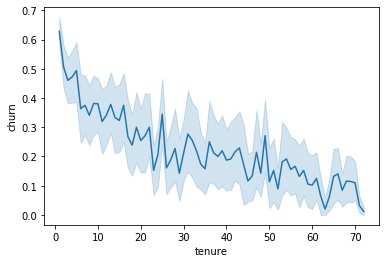

In [28]:
x = train.tenure
y = train.churn
sns.lineplot(x, y)

- Yes, the month they signed up can effect churn. There is a disproportionate number of customers churning in the first month, and to get better insights beyond just the noise of the first month, I am going to create a dataframe that drops the rows with churn in the first month.

- There are 613/7032 rows of customers who have only one month of tenure. That count drops to 238 by two months, 200 by three months, and continues to drop until the twleve month mark.


In [29]:
train.groupby(by="completed_years").completed_years.count()

completed_years
0.0    1005
1.0     827
2.0     717
3.0     502
4.0     607
5.0     540
6.0     724
Name: completed_years, dtype: int64

- Here I created a dataframe named "df_tenure_control" to explore the difference in keeping or dropping the customers with one to six months tenure.

In [30]:
months = [1, 2, 3, 4, 5, 6]
df_tenure_control = train.drop(train[train.tenure.isin(months)].index)
df_tenure_control["tenure"].value_counts().sort_index()

7      88
8      88
9      84
10     92
11     72
12     79
13     82
14     57
15     65
16     64
17     56
18     67
19     50
20     55
21     48
22     70
23     59
24     63
25     58
26     56
27     53
28     44
29     42
30     52
31     47
32     47
33     41
34     46
35     57
36     36
37     47
38     45
39     41
40     48
41     47
42     51
43     48
44     29
45     43
46     60
47     42
48     49
49     48
50     44
51     46
52     56
53     44
54     47
55     45
56     54
57     38
58     46
59     38
60     49
61     56
62     47
63     50
64     64
65     53
66     57
67     71
68     69
69     70
70     82
71    124
72    251
Name: tenure, dtype: int64

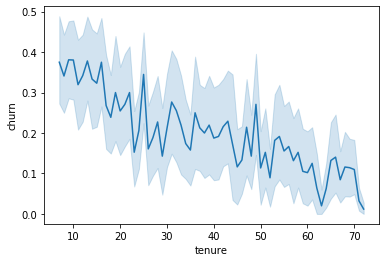

In [31]:
x = df_tenure_control.tenure
y = df_tenure_control.churn
sns.lineplot(x, y)

- Distribution of tenure

(array([1181.,  531.,  410.,  375.,  326.,  327.,  315.,  330.,  350.,
         777.]),
 array([ 1. ,  8.1, 15.2, 22.3, 29.4, 36.5, 43.6, 50.7, 57.8, 64.9, 72. ]),
 <a list of 10 Patch objects>)

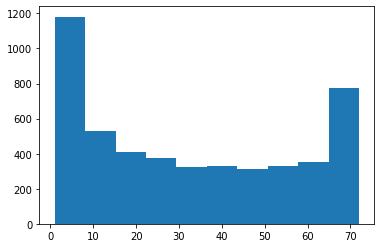

In [32]:
plt.hist(train["tenure"])

### Exploring data to create customer profiles

Data Dictionary:

- Monthly

    -1 = True
    
    -2 = False

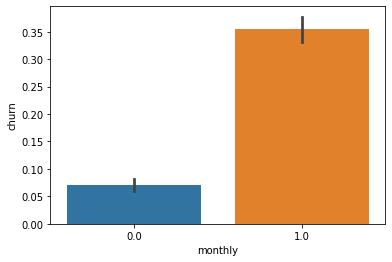

In [33]:
sns.barplot(data=df_tenure_control, x="monthly", y="churn")

Data Dictionary:

    -0 = False
    
    -1 = True

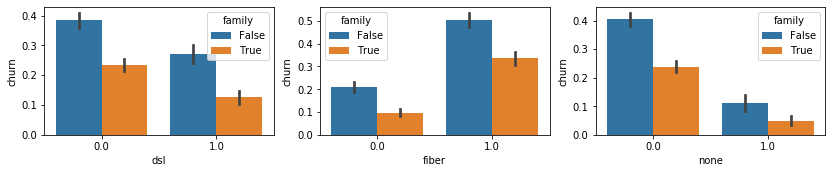

In [34]:
plt.figure(figsize=(14,8))
plt.subplot(3,3,1)
sns.barplot(x="dsl", y="churn", data=train, hue="family")
plt.subplot(3,3,2)
sns.barplot(x="fiber", y="churn", data=train, hue="family")
plt.subplot(3,3,3)
sns.barplot(x="none", y="churn", data=train, hue="family")

Data Dictionary:

- Family

    -True = partner and/or dependents
    
    -False = no partner or dependents
    

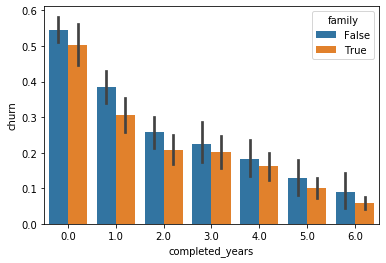

In [35]:
sns.barplot(data=train, x="completed_years", y="churn", hue="family")

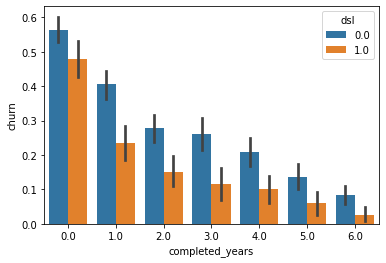

In [36]:
sns.barplot(data=train, x="completed_years", y="churn",hue="dsl")

Data Dictionary:

- DSL

    -0 = False
    
    -1 = True
    
    
- Family

    -True = partner and/or dependents
    
    -False = no partner or dependents

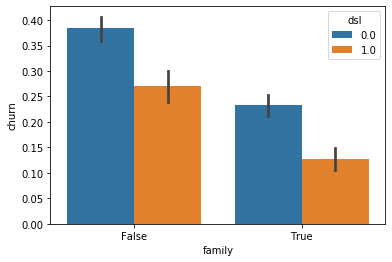

In [37]:
sns.barplot(data=train, x="family", y="churn", hue="dsl")

Data Dictionary:

- DSL

    -0 = False
    
    -1 = True


- Senior citizen

    -0 = False
    
    -1 = True

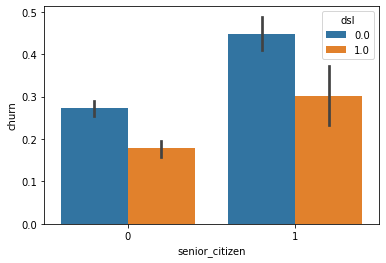

In [38]:

sns.barplot(data=train, x="senior_citizen", y="churn", hue="dsl")

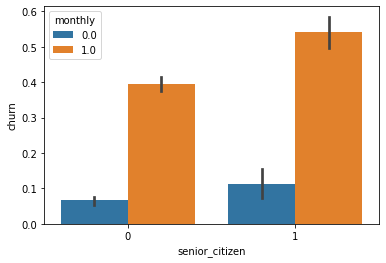

In [39]:
sns.barplot(data=train, x="senior_citizen", y="churn", hue="monthly")

3. Is there a price threshold for specific services where the liklihood of churn increases? What services and at what price point?


4. Looking at churn rate for month-to-month vs. 1-year contract customers after their 12th month of service, is the rate of churn different?

In [40]:
#train["contract_type_id"].value_counts()
(train.tenure == 12) & (train.contract_type_id == "month_to_month")

5968    False
3585    False
6987    False
5060    False
3992    False
6836    False
6991    False
1079    False
4833    False
4901    False
4784    False
352     False
382     False
6844    False
2262    False
6361    False
6052    False
2074    False
6195    False
1112    False
4870    False
5778    False
5046    False
4679    False
3564    False
5769    False
5836    False
2140    False
6149    False
3960    False
1702    False
4938    False
3317    False
1044    False
5141    False
3413    False
5763    False
5224    False
2873    False
5911    False
4572    False
1007    False
845     False
2670    False
6367    False
3625    False
1068    False
3798    False
5417    False
5834    False
3577    False
1193    False
3723    False
5584    False
5030    False
2295    False
3560    False
6401    False
5565    False
4656    False
5425    False
3323    False
6214    False
460     False
2083    False
1605    False
4249    False
2953    False
1304    False
6208    False
4995    False
4359  

5. Use a t-test to find out of the monthly charges of those who have
churned is significantly higher thatn those who have not. Control for:
(phone_id, internet_service_type_id, online_security_backup, device_protection, 
tech_support, and contract_type_id)


- Customers with DSL who have not churned:

In [41]:
no_churn_dsl = train[(train["internet_service_type_id"] == 1) & (train["churn"] == False)]

- Customers with DSL who have churned:

In [42]:
churn_dsl = train[(train["internet_service_type_id"] == 1) & (train["churn"] == True)]

- Customers with Fiber who have not churned:

In [43]:
no_churn_fiber = train[(train["internet_service_type_id"] == 2) & (train["churn"] == False)]

- Customers with DSL who have churned:

In [44]:
churn_fiber = train[(train["internet_service_type_id"] == 2) & (train["churn"] == True)]

- Calculate mean of monthly_charges for DSL customers who have not churned.

In [45]:
dsl_no_churn_monthly = no_churn_dsl["monthly_charges"].mean()
print(f"The mean of monthly charges for DSL customers who have not churned is: ")
print(dsl_no_churn_monthly)

The mean of monthly charges for DSL customers who have not churned is: 
60.149708454810494


- Calculate mean of monthly_charges for DSL customers who have churned.

In [46]:
dsl_churn_monthly = churn_dsl["monthly_charges"].mean()
print(f"The mean of monthly charges for DSL customers who have churned is: ")
print(dsl_churn_monthly)

The mean of monthly charges for DSL customers who have churned is: 
48.97953846153845


- Calculate mean of monthly_charges for Fiber customers who have not churned.

In [47]:
fiber_no_churn_monthly = no_churn_fiber["monthly_charges"].mean()
print(f"The mean of monthly charges for Fiber customers who have not churned is: ")
print(fiber_no_churn_monthly)

The mean of monthly charges for Fiber customers who have not churned is: 
93.8604299363058


- Calculate mean of monthly_charges for Fiber customers who have churned.

In [48]:
fiber_churn_monthly = churn_fiber["monthly_charges"].mean()
print(f"The mean of monthly charges for Fiber customers who have churned is: ")
print(fiber_churn_monthly)

The mean of monthly charges for Fiber customers who have churned is: 
88.16048834628198


#### Actual T-test

In [49]:
test_results = stats.ttest_ind(no_churn_dsl.monthly_charges, churn_dsl.monthly_charges)
print(f"The test statistic for DSL customers who churn vs. those who don't churn is: {test_results[0]}")
print(f"The p-value of the test is: ")
print(test_results[1])

The test statistic for DSL customers who churn vs. those who don't churn is: 11.578298166663087
The p-value of the test is: 
6.844185456987299e-30


In [50]:
test_results = stats.ttest_ind(no_churn_fiber.monthly_charges, churn_fiber.monthly_charges)
print(f"The test statistic for Fiber customers who churn vs. those who don't churn is: {test_results[0]}")
print(f"The p-value of the test is: ")
print(test_results[1])

The test statistic for Fiber customers who churn vs. those who don't churn is: 10.584086721880396
The p-value of the test is: 
1.4796197678260636e-25


6. Perform a correlation test, stating hypothesis and conclusion clearly that states if monthly charges can be explained by internet_service_type


$H_0$: The Null Hypothesis is that the monthly charges cannot be explained by internet_service_type.

$H_a$: The Null Hypothesis is that the monthly charges can be explained by internet_service_type.

7. How much of monthly_charges can be explained by internet_service_type + phone service type (0, 1, or multiple lines). State your hypotheses and your conclusion clearly.




$H_0$: The Null Hypothesis is that the monthly charges cannot be explained by internet_service_type + phone_service_type.

$H_a$: The Null Hypothesis is that the monthly charges can be explained by internet_service_type + phone_service_type.

8. Create visualizations exploring the interactions of variables (independent with independent and independent with dependent). The goal is to identify features that are related to churn, identify any data integrity issues, understand 'how the data works'. For example, we may find that all who have online services also have device protection. In that case, we don't need both of those. (The visualizations done in your analysis for questions 1-5 count towards the requirements below)



9. What can you say about each variable's relationship to churn, based on your initial exploration? If there appears to be some sort of interaction or correlation, assume there is no causal relationship and brainstorm (and document) ideas on reasons there could be correlation.




10. Summarize your conclusions, provide clear answers to the specific questions, and summarize any takeaways/action plan from the work above.




### Scale Data Using MinMaxScaler

In [51]:
column_list = ["monthly_charges", "total_charges", "tenure", "completed_years"]
x_train, x_test, scaler = scale_minmax(x_train, x_test, column_list)

In [52]:
x_train.head()
x_test.head()

,internet_service_type_id,contract_type_id,gender,senior_citizen,tenure,phone_service,multiple_lines,monthly_charges,total_charges,completed_years,...,dsl,fiber,none,monthly,1-year,2-year,monthly_charges_scaled,total_charges_scaled,tenure_scaled,completed_years_scaled
6934,3,3,1,0,71,True,False,20.50,1500.95,6.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.020958,0.171030,0.985915,1.000000
928,1,1,0,0,6,True,False,44.60,260.80,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.261477,0.027925,0.070423,0.000000
4880,2,2,1,1,72,True,True,105.00,7578.05,6.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.864271,0.872288,1.000000,1.000000
3828,2,1,0,0,1,True,False,69.35,69.35,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.508483,0.005833,0.000000,0.000000
6441,3,3,0,0,50,True,False,19.80,1013.20,4.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.013972,0.114747,0.690141,0.666667


### Modeling

#### Feature selection: can you remove any features that provide limited to no additional info?


In [53]:
x_train.drop(columns=["internet_service_type_id", "contract_type_id", "monthly_charges", "total_charges", "tenure", "completed_years"], axis=1, inplace=True)

In [54]:
x_test.drop(columns=["internet_service_type_id", "contract_type_id", "monthly_charges", "total_charges", "tenure", "completed_years"], axis=1, inplace=True)

## Train Baseline Model

### Create the Decision Tree Object

In [55]:

clf = DecisionTreeClassifier(max_depth=3, random_state=123)

### Fit the model to the training data

In [56]:
x_train.shape

(4922, 17)

In [57]:
y_train.shape

(4922, 1)

In [58]:
clf.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

### Estimate Churn

In [59]:
y_pred = clf.predict(x_train)
y_pred[0:5]

array([False,  True, False, False, False])

### Estimate the probability of churn

In [60]:
y_pred_proba = clf.predict_proba(x_train)
y_pred_proba

array([[0.81208936, 0.18791064],
       [0.30837004, 0.69162996],
       [0.98447894, 0.01552106],
       ...,
       [0.30837004, 0.69162996],
       [0.30837004, 0.69162996],
       [0.92972182, 0.07027818]])

## Evaluate Model


In [61]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(x_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.79


## Create a confusion matrix

- True Positive: number of occurrences where y is true and y is predicted true.

- True Negative: number of occurrences where y is false and y is predicted false.

- False Positive: number of occurrences where y is false and y is predicted true.

- False Negative: number of occurrences where y is true and y is predicted false.


In [62]:
cm = pd.DataFrame(confusion_matrix(y_train, y_pred))
cm

,0,1
0,3404,210
1,837,471


### Findings After Running Decision Tree Model with Unscaled Data

- This confustion matrix tells me that my model is better at predicting True Negatives than True Positives.


- The model predicts at an overall accuracy rate of 78%


- However, the Recall rate for customers who churn is 37% which means that the model is not predicting the positives for churn very well. It is at 93% for predicting the customers who will not churn, so my model is out of balance. 


- I want to be able to better predict the customers who will churn, so we can create personas and more accurately target them with strategies that will keep them from churning.

### Create a classification report

- Precision: the higher this number is, the more you were able to pinpoint all positives correctly. If this is a low score, you predicted a lot of positives where there were none. tp / (tp + fp)


- Recall: if this score is high, you didn’t miss a lot of positives. But as it gets lower, you are not predicting the positives that are actually there. tp / (tp + fn)


- f1-score: The balanced harmonic mean of Recall and Precision, giving both metrics equal weight. The higher the F-Measure is, the better.


- Support: number of occurrences of each class in where y is true.

In [63]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

       False       0.80      0.94      0.87      3614
        True       0.69      0.36      0.47      1308

    accuracy                           0.79      4922
   macro avg       0.75      0.65      0.67      4922
weighted avg       0.77      0.79      0.76      4922



## Train Model 

### Create the Logistic Regression Object

In [64]:
logit = LogisticRegression(random_state = 123, solver='saga')

### Train 

- (fit, transform, evaluate) multiple models and select the best performing model.


In [65]:
logit.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=123, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

### Compare eval metrics across all the models and select best performing


- Print the coefficients and intercept of the model


In [66]:
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

Coefficient: 
 [[ 0.08513601  0.28776881 -0.91334532  0.23380946 -0.1479889   0.17372898
  -0.50780396 -0.07676468  0.77651662 -0.70788     0.8298527   0.05375959
  -0.89174035  0.85861224  0.9633632  -1.90316312 -0.90729483]]
Intercept: 
 [-0.49153457]


### Estimate whether or not a customer will churn


In [67]:
y_pred = logit.predict(x_train)
y_pred[0:5]

array([False,  True, False, False,  True])

### Estimate the probability of a customer churning using the train data

In [68]:
y_pred_proba = logit.predict_proba(x_train)
y_pred_proba

array([[0.83776219, 0.16223781],
       [0.33654453, 0.66345547],
       [0.98864952, 0.01135048],
       ...,
       [0.36319381, 0.63680619],
       [0.32373784, 0.67626216],
       [0.89077844, 0.10922156]])

### Evaluate

- Compute the accuracy


In [69]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(x_train, y_train)))


Accuracy of Logistic Regression classifier on training set: 0.80


### Create a confusion matrix


In [70]:
print(confusion_matrix(y_train, y_pred))

[[3247  367]
 [ 627  681]]


### Compute Precision, Recall, F1-score, and Support

In [71]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

       False       0.84      0.90      0.87      3614
        True       0.65      0.52      0.58      1308

    accuracy                           0.80      4922
   macro avg       0.74      0.71      0.72      4922
weighted avg       0.79      0.80      0.79      4922



### Findings After Training Decision Tree Baseline v. Logistic Regression Models with Unscaled Data

- The Logistic Regression model predicts at an overall accuracy rate of 78%


- However, the Recall rate for customers who churn is 48% as opposed to the 36% Recall rate for the Decision Tree model. It is at 87% for predicting the customers who will not churn, as opposed to the 93% Recall rate for customers who will not churn using the decision tree.


- This LR model DOES better predict the customers who will churn than the Decision Tree model, but I still want to do feature selection and engineering to improve my model's accuracy at predicting suctomer churn.

### Create Model After Feature Selection

### Test 

- Test the final model (tranform, evaluate) on your out-of-sample data. Summarize the performance, interpret results.
